In [1]:
from tf_util_y import *
from DP import DataLoader
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
dFFBC = DataLoader(data_name = "FFBC400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")
dRH = DataLoader(data_name = "RH400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")
dMMM = DataLoader(data_name = "MMM400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")
dBA = DataLoader(data_name = "BA400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")
dNYT = DataLoader(data_name = "NYT400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")
dBABA = DataLoader(data_name = "BABA400_8_",mode = "reg",p_day = 20,train_prob = 0.8)(p_type = "hl")


In [3]:
len(dFFBC["X_tr"]),len(dRH["X_tr"]),len(dMMM["X_tr"]),len(dBA["X_tr"]),len(dNYT["X_tr"]),len(dBABA["X_tr"])

(5161, 704, 9308, 10918, 8653, 325)

In [4]:
idx = np.random.choice(range(5161),600)
FFBCXTR = dFFBC["X_tr"][idx]
FFBCYTR = dFFBC["Y_tr"][idx]
idx = np.random.choice(range(704),600)
RHXTR = dRH["X_tr"][idx]
RHYTR = dRH["Y_tr"][idx]
idx = np.random.choice(range(9308),600)
MMMXTR = dMMM["X_tr"][idx]
MMMYTR = dMMM["Y_tr"][idx]
idx = np.random.choice(range(10918),600)
BAXTR = dBA["X_tr"][idx]
BAYTR = dBA["Y_tr"][idx]
idx = np.random.choice(range(8653),600)
NYTXTR = dNYT["X_tr"][idx]
NYTYTR = dNYT["Y_tr"][idx]

MixXtr = np.concatenate([FFBCXTR,RHXTR,MMMXTR,BAXTR,NYTXTR])
MixYtr = np.concatenate([FFBCYTR,RHYTR,MMMYTR,BAYTR,NYTYTR])

In [5]:
class model6(MODEL):
    def __init__(self,name = "defmodel6"):
        MODEL.__init__(self,name)
        
        self.X = tf.placeholder(shape=[None,20,50,18],dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None,2],dtype=tf.float32)
        
        self.BNX = BN(self.X,name=self.name+"BNX")
        
        self.S0 = CONV2D(self.BNX,[1,50,18,50],name=self.name+"S0")
        self.S1 = CONV2D(self.BNX,[20,1,18,20],name=self.name+"S1")
        self.SA = CONV2D(self.BNX,[3,3,18,50],padding="SAME",name=self.name+"SA")
        self.SB = CONV2D(self.BNX,[5,5,18,50],padding="SAME",name=self.name+"SB")
        
        self.ASA = ACT(PLUSB(self.SA,name=self.name+"bASA"),name=self.name+"ASA")
        self.ZA = CONV2D(self.ASA,[5,5,50,60],padding="SAME",name=self.name+"ZA")
        self.AZA = ACT(PLUSB(self.ZA,name=self.name+"bAZA"),name=self.name+"AZA")
        self.BNAZA = BN(self.AZA,name=self.name+"BNAZA")
        
        self.ASB = ACT(PLUSB(self.SB,name=self.name+"bASB"),name=self.name+"ASB")
        self.ZB = CONV2D(self.ASB,[3,3,50,60],padding="SAME",name=self.name+"ZB")
        self.AZB = ACT(PLUSB(self.ZB,name=self.name+"AZB"),name=self.name+"AZB")
        self.BNAZB = BN(self.AZB,name=self.name+"BNAZB")
        
        self.AS0 = ACT(PLUSB(self.S0,name=self.name+"bAS0"),name=self.name+"AS0")
        self.Z0 = tf.transpose(self.AS0,[0,1,3,2])
        
        self.AS1 = ACT(PLUSB(self.S1,name=self.name+"bAS1"),name=self.name+"AS1")
        self.Z1 = tf.transpose(self.AS1,[0,3,2,1])
        
        self.CC = tf.concat([self.Z0,self.Z1],axis = 3)
        self.ACC = ACT(PLUSB(self.CC,name=self.name+"bACC"),name=self.name+"ACC")
        self.ZCC = CONV2D(self.ACC,[3,3,2,50],padding="SAME",name=self.name+"ZCC")
        self.CCS = tf.concat([self.BNAZA,self.BNAZB,self.ZCC],axis=3)
        self.P0 = tf.nn.avg_pool(self.CCS,ksize=[1,5,5,1],strides=[1,5,5,1],padding="VALID")
        self.ZP0 = CONV2D(self.P0,[3,3,170,200],name=self.name+"ZP0")
        self.AP0 = ACT(PLUSB(self.ZP0,name=self.name+"bAP0"),name=self.name+"AP0")
        self.ZZ0 = CONV2D(self.AP0,[1,8,200,200])
        self.A0 = ACT(PLUSB(self.ZZ0,name=self.name+"bA0"),name=self.name+"A0")
        self.BNA0 = BN(self.A0,name=self.name+"BNA0")
        self.ZZ1 = CONV2D(self.BNA0,[2,1,200,210],name=self.name+"ZZ1")
        self.F = tf.contrib.layers.flatten(self.ZZ1)
        self.ZF = FC(self.F,260,name=self.name+"ZF")
        self.AF = ACT(PLUSB(self.ZF,name=self.name+"bAF"),name=self.name+"AF")
        self.ZF1 = FC(self.AF,100,name=self.name+"ZF1")
        self.AF1 = ACT(PLUSB(self.ZF1,name=self.name+"bAF1"),name=self.name+"AF1")
        self.ZF2 = FC(self.AF1,20,name=self.name+"ZF2")
        self.AF2 = ACT(PLUSB(self.ZF2,name=self.name+"nAF2"),name=self.name+"AF2")
        self.BNAF2 = BN(self.AF2,name=self.name+"BNAF2")
        self.OUP = FC(self.BNAF2,2,name=self.name+"OUP")
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.OUP*100,self.Y*100))
        self.opt = tf.train.AdadeltaOptimizer(30).minimize(self.cost)
        self.init = tf.global_variables_initializer()

In [140]:
m.close()

In [6]:
tf.reset_default_graph()
m = model6()

In [7]:
m.open()

<IPython.core.display.Javascript object>


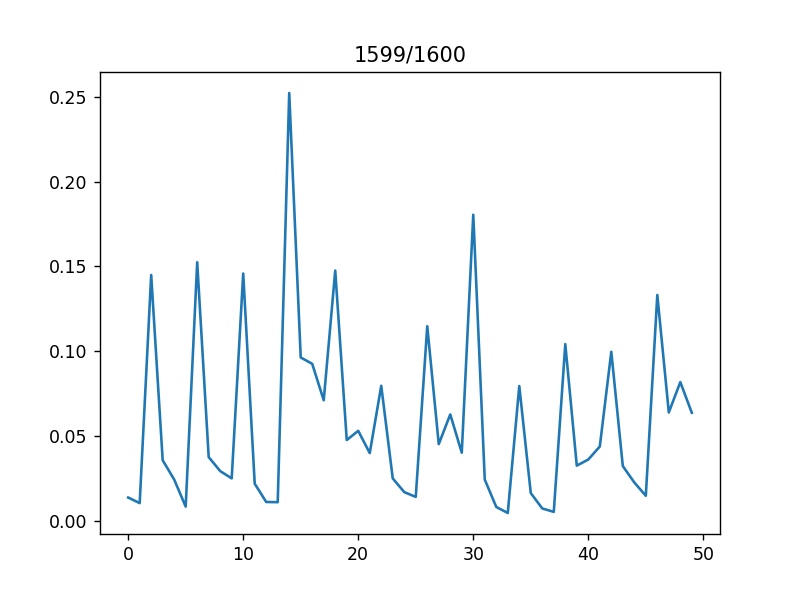

In [8]:
m.train_minib(MixXtr,MixYtr,bloop=4,bsize = 128,loop=1600)

In [10]:
from functools import reduce
def count_params():
    size = lambda v: reduce(lambda x, y: x*y, v.get_shape().as_list() + [1])
    n = sum(size(v) for v in tf.global_variables())
    print ("Model size: %dK" % (n/1000,))
    return n

In [11]:
count_params()

Model size: 5818K


5818076

In [19]:
YY0 = dBABA["Y_tr"][0:512]
yy0 = m.sess.run(m.OUP,feed_dict={m.X:dBABA["X_tr"][0:512]})
print("BABA test",len(YY0))
print("0.01 test",(abs(YY0[:,0] - yy0[:,0])<0.01).sum()/len(yy0),(abs(YY0[:,1] - yy0[:,1])<0.01).sum()/len(yy0))
print("std test",abs(yy0[:,0].std()),abs(yy0[:,1].std()),abs(YY0[:,0]).std(),abs(YY0[:,1]).std())
print("min max test",yy0[:,0].max(),yy0[:,1].min(),YY0[:,0].max(),YY0[:,1].min())

BABA test 325
0.01 test 0.483076923077 0.507692307692
std test 0.0117745 0.00720041 0.0131683659715 0.0122584323444
min max test 0.0725802 -0.0358508 0.143744030564 -0.0700091060046


In [20]:
YY0 = dRH["Y_te"][0:512]
yy0 = m.sess.run(m.OUP,feed_dict={m.X:dRH["X_te"][0:512]})
print("RH test",len(YY0))
print("0.01 test",(abs(YY0[:,0] - yy0[:,0])<0.01).sum()/len(yy0),(abs(YY0[:,1] - yy0[:,1])<0.01).sum()/len(yy0))
print("std test",abs(yy0[:,0].std()),abs(yy0[:,1].std()),abs(YY0[:,0]).std(),abs(YY0[:,1]).std())
print("min max test",yy0[:,0].max(),yy0[:,1].min(),YY0[:,0].max(),YY0[:,1].min())

RH test 161
0.01 test 0.32298136646 0.416149068323
std test 0.0140753 0.00909993 0.0338271214649 0.0333286547123
min max test 0.084151 -0.0476085 0.310043668122 -0.287365177196


In [21]:
YY0 = dFFBC["Y_te"][0:512]
yy0 = m.sess.run(m.OUP,feed_dict={m.X:dFFBC["X_te"][0:512]})
print("FFBC test",len(YY0))
print("0.01 test",(abs(YY0[:,0] - yy0[:,0])<0.01).sum()/len(yy0),(abs(YY0[:,1] - yy0[:,1])<0.01).sum()/len(yy0))
print("std test",abs(yy0[:,0].std()),abs(yy0[:,1].std()),abs(YY0[:,0]).std(),abs(YY0[:,1]).std())
print("min max test",yy0[:,0].max(),yy0[:,1].min(),YY0[:,0].max(),YY0[:,1].min())

FFBC test 512
0.01 test 0.40234375 0.4296875
std test 0.0126074 0.00942304 0.0260242916546 0.0266138607796
min max test 0.0669881 -0.06282 0.0980952380952 -0.503224681889
